# Installation et importation des packages python

In [43]:
! pip install -q keras

In [2]:
from glob import glob
import tarfile
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

# Extraction des images de chien

In [3]:
base_dir = 'Images'
if(os.path.exists(base_dir)): shutil.rmtree(base_dir)
for file in glob("images.tar*"):
    os.remove(file)
! wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar --no-check-certificate

my_tar = tarfile.open('images.tar')
my_tar.extractall()
my_tar.close()

--2021-03-11 10:50:32--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  14.3MB/s    in 37s     

2021-03-11 10:51:09 (20.3 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [ ]:
# selection de 10 images du dossier Images
os.listdir(f'{base_dir}/n02085620-Chihuahua')[:10]

['n02085620_2921.jpg',
 'n02085620_2973.jpg',
 'n02085620_7292.jpg',
 'n02085620_13151.jpg',
 'n02085620_13964.jpg',
 'n02085620_1916.jpg',
 'n02085620_3402.jpg',
 'n02085620_588.jpg',
 'n02085620_3208.jpg',
 'n02085620_5927.jpg']

# Séparation du jeu de données

In [45]:
valid_dir = 'valid'
train_dir = 'train'

if(os.path.exists(train_dir)): shutil.rmtree(train_dir)
if(os.path.exists(valid_dir)): shutil.rmtree(valid_dir)

os.mkdir(valid_dir)
os.mkdir(train_dir)

for d in os.listdir(base_dir):
    dogs = os.listdir(f"{base_dir}/{d}")
    valid_len = int(len(dogs) * 0.3)
    train_len = len(dogs) - valid_len

    os.mkdir(f"{valid_dir}/{d}")
    os.mkdir(f"{train_dir}/{d}")

    for dog in dogs[:valid_len]:
        shutil.copy(f'{base_dir}/{d}/{dog}', f'{valid_dir}/{d}/{dog}')

    for dog in dogs[valid_len:len(dogs)]:  # [pointdepart: nombrediteration]
        shutil.copy(f'{base_dir}/{d}/{dog}', f'{train_dir}/{d}/{dog}')

In [6]:
# on check la proportion d'images entre train et validimport sys
train_data = []
valid_data = []
total_data = []
for d in os.listdir(train_dir): 
  train_data += os.listdir(f'{train_dir}/{d}')
for d in os.listdir(valid_dir): 
  valid_data += os.listdir(f'{valid_dir}/{d}')
for d in os.listdir(base_dir): 
  total_data += os.listdir(f'{base_dir}/{d}')

print('total training dog images:', len(train_data))
print('total validating dog images:', len(valid_data))
print('total:', len(train_data) + len(valid_data))
print('nombre d\'images à l\'origine:', len(total_data))

total training dog images: 14458
total validating dog images: 6122
total: 20580
nombre d'images à l'origine: 20580


In [7]:
train_df = pd.DataFrame.from_dict(
    [{ 
        "name": d, 
        "count": len(os.listdir(f'{train_dir}/{d}'))
    } for d in os.listdir(train_dir)]
)
train_df

,name,count
0,n02115641-dingo,110
1,n02097130-giant_schnauzer,110
2,n02086646-Blenheim_spaniel,132
3,n02087394-Rhodesian_ridgeback,121
4,n02093256-Staffordshire_bullterrier,109
...,...,...
115,n02090721-Irish_wolfhound,153
116,n02096051-Airedale,142
117,n02093647-Bedlington_terrier,128
118,n02090622-borzoi,106


In [8]:
valid_df = pd.DataFrame.from_dict(
    [{ 
        "name": d, 
        "count": len(os.listdir(f'{valid_dir}/{d}'))
    } for d in os.listdir(valid_dir)]
)
valid_df

,name,count
0,n02115641-dingo,46
1,n02097130-giant_schnauzer,47
2,n02086646-Blenheim_spaniel,56
3,n02087394-Rhodesian_ridgeback,51
4,n02093256-Staffordshire_bullterrier,46
...,...,...
115,n02090721-Irish_wolfhound,65
116,n02096051-Airedale,60
117,n02093647-Bedlington_terrier,54
118,n02090622-borzoi,45


In [9]:
valid_df.name.values.tolist()[:10]

['n02115641-dingo',
 'n02097130-giant_schnauzer',
 'n02086646-Blenheim_spaniel',
 'n02087394-Rhodesian_ridgeback',
 'n02093256-Staffordshire_bullterrier',
 'n02095570-Lakeland_terrier',
 'n02107312-miniature_pinscher',
 'n02105855-Shetland_sheepdog',
 'n02106166-Border_collie',
 'n02106030-collie']

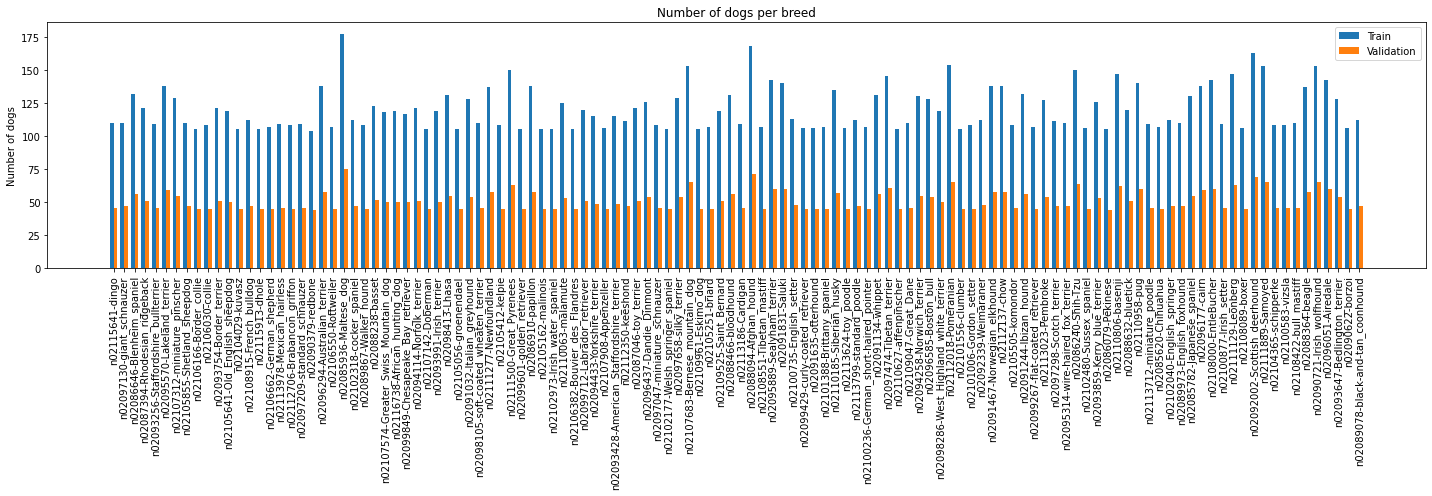

In [46]:
fig, ax = plt.subplots(figsize=(20, 7))
x = np.arange(len(train_df['name'].values))

width = 0.35
rects1 = ax.bar(x - width/2, train_df['count'].values, width, label='Train')
rects2 = ax.bar(x + width/2, valid_df['count'].values, width, label='Validation')

ax.set_ylabel('Number of dogs')
ax.set_title('Number of dogs per breed')
ax.set_xticks(x)
ax.set_xticklabels(train_df['name'].values, rotation='vertical')
ax.legend()

fig.tight_layout()
plt.show()

# Transfer Learning

## Instanciation de VGG16

In [13]:
#del model_VGG16
model_VGG16 = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None)
model_VGG16.summary()

553467904/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
from keras.preprocessing import image
# Chargement et redimension (VGG16 étant entraîné sur des images 224 x 224)
img = image.load_img('/content/Images/n02085620-Chihuahua/n02085620_10074.jpg', target_size=(224,224))

# Transformation image en array de pixels
ary = image.img_to_array(img)
ary = np.expand_dims(ary, axis=0)

# Predictions de la race de chien
preds = model_VGG16.predict(preprocess_input(ary))
results = decode_predictions(preds, top=5)[0]
for result in results:
  print(result)

('n02085620', 'Chihuahua', 0.999257)
('n02087046', 'toy_terrier', 0.00032874296)
('n02096585', 'Boston_bull', 6.726792e-05)
('n02105412', 'kelpie', 5.643923e-05)
('n02108915', 'French_bulldog', 5.285305e-05)


## Personnalisation du modèle

In [24]:
# recupération de toutes les couches du VGG16 sauf output
personal_model = Sequential()
for layer in model_VGG16.layers[:-1]:
    personal_model.add(layer)
    
personal_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [15]:
# on précise à chaque couche qu’on ne souhaite pas effectuer un nouvel entraînement
for layer in personal_model.layers:
    layer.trainable = False

In [39]:
[layer.trainable for layer in personal_model.layers]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True]

In [34]:
# ajout de la couche de sortie avec le bon nombre de classes
personal_model.add(Dense(units=len(valid_df.name.values.tolist()), activation='softmax'))

In [35]:
personal_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [36]:
personal_model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])

In [55]:
train_datagen_personal_vgg = ImageDataGenerator(rescale=1./255)
  
val_datagen_personal_vgg = ImageDataGenerator(rescale=1./255)

train_img_nb = len(train_data)
valid_img_nb = len(valid_data)
batch_size = 20
epochs = 15

# Flow training images using train_datagen generator
train_generator = train_datagen_personal_vgg.flow_from_directory(
    train_dir,  # This is the source directory for training images
    target_size=(224, 224),  # All images will be resized to 150x150
    batch_size=batch_size,
    classes=valid_df.name.values.tolist()
)

# Flow validation images in batches of 20 using val_datagen generator
valid_generator = val_datagen_personal_vgg.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    classes=valid_df.name.values.tolist()
)

batch_stats_callback = CollectBatchStats()


history = personal_model.fit(
    train_generator,
    steps_per_epoch=int(train_img_nb / batch_size),
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=int(valid_img_nb / batch_size),
    verbose=2,
    callbacks=[batch_stats_callback]
)

Found 14458 images belonging to 120 classes.
Found 6122 images belonging to 120 classes.
Epoch 1/15
722/722 - 111s - loss: 4.7082 - acc: 0.3000 - val_loss: 4.6678 - val_acc: 0.2052
Epoch 2/15
722/722 - 111s - loss: 2.6021 - acc: 0.5000 - val_loss: 4.7205 - val_acc: 0.2041
Epoch 3/15
722/722 - 110s - loss: 2.4501 - acc: 0.4000 - val_loss: 4.6149 - val_acc: 0.2072
Epoch 4/15
722/722 - 111s - loss: 2.8080 - acc: 0.5000 - val_loss: 4.5796 - val_acc: 0.2033
Epoch 5/15
722/722 - 111s - loss: 3.3972 - acc: 0.2500 - val_loss: 4.7458 - val_acc: 0.1961
Epoch 6/15
722/722 - 110s - loss: 2.0587 - acc: 0.4000 - val_loss: 5.0993 - val_acc: 0.1884
Epoch 7/15
722/722 - 111s - loss: 2.1390 - acc: 0.5000 - val_loss: 5.1103 - val_acc: 0.1925
Epoch 8/15
722/722 - 111s - loss: 3.2941 - acc: 0.2000 - val_loss: 4.6682 - val_acc: 0.2087
Epoch 9/15
722/722 - 111s - loss: 2.8543 - acc: 0.3500 - val_loss: 4.9082 - val_acc: 0.2016
Epoch 10/15
722/722 - 110s - loss: 2.8218 - acc: 0.4000 - val_loss: 4.9528 - val_ac

NameError: ignored

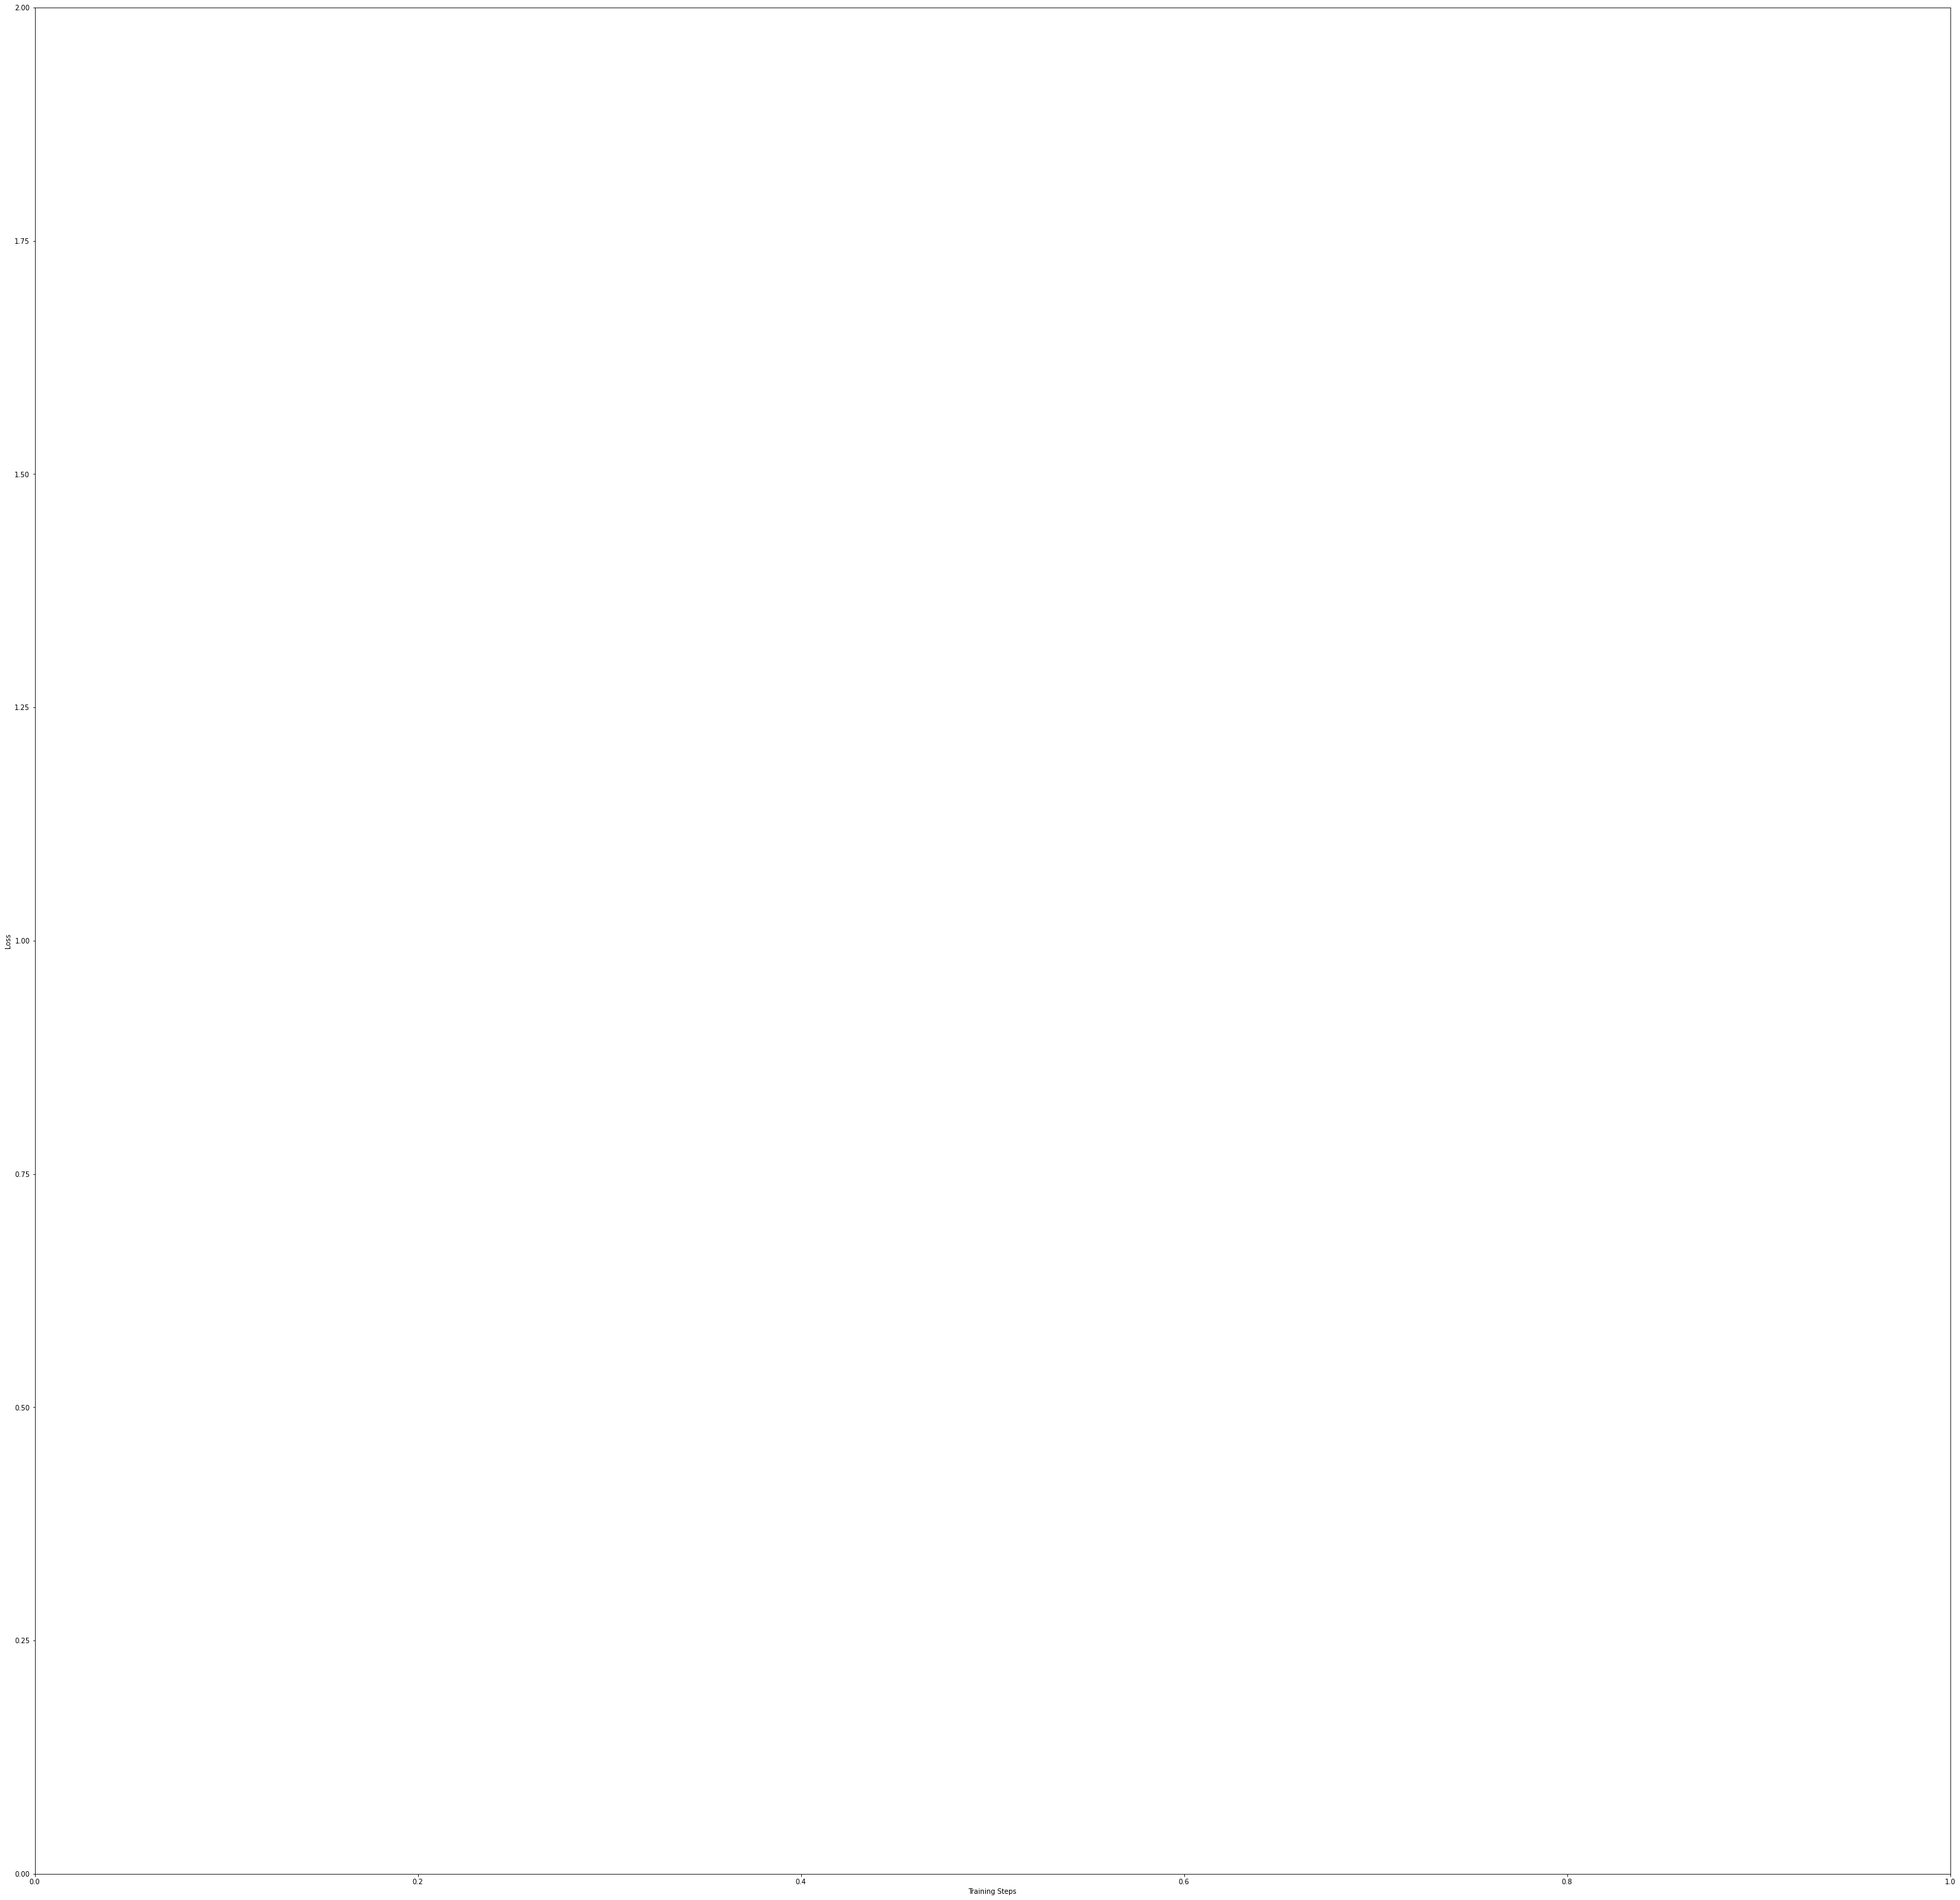

In [3]:
plt.figure(figsize=(50,50))
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_acc)